# Chapter 1 - ML Basics Lab II — Training a Simple MLP in NumPy

This notebook demonstrates how to build and train a simple Multi-Layer Perceptron (MLP) from scratch using NumPy.  
We will use a synthetic 2D dataset (`make_moons`) so that we can easily **visualize the decision boundary**.

---

## Learning Objectives
- Understand how forward and backward passes work in a neural network
- Implement **Stochastic Gradient Descent (SGD)** manually
- Explore the effect of the learning rate on training dynamics
- Visualize both the **loss curves** and the **decision boundary evolution**

---

**This week's exercise has 7 tasks for a total of 8 points. Don't forget to submit your solutions to GitHub!**

What we are trying to accomplish in this notebook is to manually build the forward and backward passes for training a model using Stochastic Gradient Descent (SGD), which we learned about in the most recent lecture. For now, we continue using Numpy to implement this process, using an extremely small model. We will switch to the more modern PyTorch in the coming weeks, and automate these calculations away - an extremely useful feature, as you will no doubt agree after this exercise.

---

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## 2. Prepare Data

We start by making ourselves a little toy dataset called "Moons". In essence, the dataset has two characteristic values, let's call them $X_{1}$ and $X_{2}$, and a class $y$.

**Task 1 (1 point)**: Get a feel for our dataset by making a scatterplot of all the data points. To differentiate the classes, have data points be colored according to their class.

If you see two distinct groups which look slightly banana-shaped, or a bit like a yin-yang symbol, you've done it right. The train and test datasets should look different, but very similar.

**Task 2 (1 point)**: Is a simpler, older model like a decision tree or a logistic regression likely to be able to differentiate classes in our dataset well? Explain why.

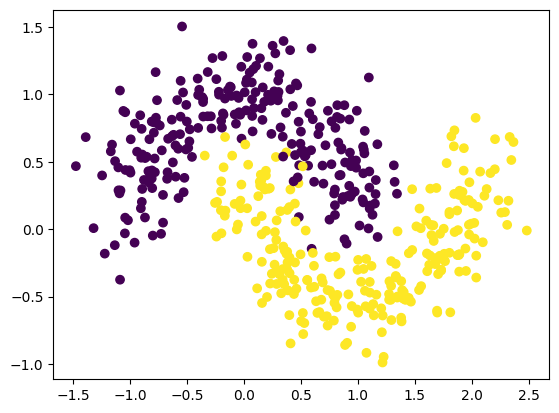

[[ 1.28895069 -0.52407983]
 [-0.90531625  0.15544401]
 [ 0.88209598  0.92005916]
 [ 1.98071107  0.34837806]
 [ 0.54265237  0.55021322]
 [ 1.81284563 -0.61631899]
 [-0.14089918  1.03314844]
 [ 0.73465258 -0.45111979]
 [ 2.34891744  0.51366081]
 [ 1.84662963  0.26194188]
 [-0.40226811  0.99592251]
 [ 1.16358607 -0.48566514]
 [-0.19969177  0.35507668]
 [ 0.34031402 -0.37512084]
 [-0.89372245  0.29883409]
 [ 1.64725174 -0.04354308]
 [ 1.69068186  0.30622198]
 [ 0.10659373  1.21210782]
 [ 1.06136666  0.72937225]
 [ 0.35326085 -0.40785615]
 [ 0.84683651  0.82025732]
 [-1.38975226  0.68338655]
 [ 1.80514983  0.12828453]
 [ 0.15321834  0.89777231]
 [ 2.26021945  0.12311908]
 [-0.83046441  0.667742  ]
 [ 0.03719828  0.47859016]
 [-0.90223258  0.53073267]
 [ 0.4786919   0.34127563]
 [ 1.8049858  -0.1747669 ]
 [ 1.3336337  -0.34689754]
 [-1.13441398 -0.11840545]
 [ 2.31239827  0.03250458]
 [ 0.88828033 -0.85874982]
 [ 2.48480165 -0.00969383]
 [-1.01875636  0.06676677]
 [ 1.15628145  0.26071784]
 

In [18]:
# Generate 2D moons dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Plot
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()
print(X_train)


#Task 2: NOOOOO, logistic regression model online makes linear seperations (not complex curves like moons)
       # Decision tree: would have to have to be too deep to fit accurately and even then the noise which causes
       #the overlap would not be able to be decided properly

## 3. Define MLP Functions

The next step is to build our Multi-layer Perceptron. While they can be arbitrarily large, for our toy dataset a small one with just two layers, a ReLU function, and a Sigmoid at the end will suffice. To do this, we will need a few functions, which are for you to implement.

**Task 3 (1 point)**: Create a Sigmoid function, a ReLU function, a ReLU derivative function, and a cross-entropy loss function.

**Task 4 (1 point)**: Create a Forward function with inputs $X$, and weights and biases for the two layers of our MLP, $W_1$, $b_1$, $W_2$ and $b_2$. As outputs, the function should obviously give back the output of our MLP, but we also want the output of all the steps inbetween, namely $X$, $z_1$ (the output after the first layer), $h_1$ (the output after the first layer and the ReLU function), and $z_2$ (the output after the second layer, but before the sigmoid). Having this information will be necessary to later compute our gradients.

**Task 5 (1 point)**: Can you think of a reason why we give the model parameters a starting value (initialization) that is different from all zeroes? Elaborate what would happen if we did.

In [30]:
# We build a **2-layer MLP**:
# - Input → Hidden (ReLU) → Output (Sigmoid)

# Activation functions
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def relu(z):
  return np.maximum(0,z)

def drelu(z, y_pred, y_true,l):
  q= [np.log(y_pred), (y_true/y_pred)-(1-y_true)/(1-y_pred)]
  l=3
  return relu(z)-l*q


# Loss function (cross-entropy, binary)
def compute_loss(y_pred, y_true):
  # log(0) vermeiden
  y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
  N = len(y_true)
  loss = 0.0
  for i in range(N):
    loss += - (y_true[i] * np.log(y_pred[i]) + (1 - y_true[i]) * np.log(1 - y_pred[i]))
  return loss/N

# Initialize weights - We start with a model that has completely random parameters
def init_weights(input_dim, hidden_dim, output_dim):
    np.random.seed(0)
    W1 = 0.1 * np.random.randn(input_dim, hidden_dim)
    b1 = np.zeros((1, hidden_dim))
    W2 = 0.1 * np.random.randn(hidden_dim, output_dim)
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

# Forward pass
def forward(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1
    h1 = relu(z1)
    z2 = h1 @ W2 + b2
    out = sigmoid(z2)
    y_pred = out
    cache = (X, z1, h1, z2, out)
    return y_pred, cache

t, r, u, i = init_weights(2, 2, 2)
MLP_test, cache = forward(X_train, t, r, u, i)

neue_parameter = drelu(3, 0.5, 0.5, 1)
print(neue_parameter)

#Task5: if you multiple with zero everything becomes zero, so nothing can be trained on

[3.69314718 3.         3.69314718 3.         3.69314718 3.        ]


## 4. Gradient Descent

**Task 6 (2 points)**: Next, implement a single step of stochastic gradient descent, using the functions you just made. Most code is already filled in, except for the gradients. These are for you to compute.

1. Forward pass - Compute the model predictions, using the forward function you just defined
2. Loss - Compute the loss, using the loss function you just defined
3. Backward pass - Compute the gradients for $W_1$, $b_1$, $W_2$, and $b_2$. Each of these is a full derivative of the Loss with respect to the parameter in question. This involves multiple applications of the chain rule. We kept track of the values of the intermediate calculation steps for this purpose.
4. Apply SGD update - Subtract $lr * gradient$ from each parameter.
5. Return updated parameters and current loss.

In [31]:
# --- Gradient computation + SGD update ---


def step(W1, b1, W2, b2, X, y, lr=0.1):
    """
    Perform one optimization step with SGD.

    Inputs:
        W1, b1, W2, b2 : current weights and biases
        X : input data batch, shape (N, d)
        y : labels, shape (N, 1)
        lr : learning rate (float)

    Returns:
        Updated weights W1, b1, W2, b2
        Current loss (float)
    """

    # Forward
    y_pred, cache = forward(X, W1, b1, W2, b2)

    # Loss
    loss = compute_loss(y_pred, y)

    # Backward (gradients)
    X_, z1, h1, z2, out = cache
    m = X_.shape[0]

    dz2 = (y_true/y_pred - (1-y_true)/(1-y_pred)) * (np.exp(z2))/(np.exp(z2)+1)^2
    dW2 = ((y_true/y_pred - (1-y_true)/(1-y_pred)) * (np.exp(z2))/(np.exp(z2)+1)^2) * h1
    db2 = ((y_true/y_pred - (1-y_true)/(1-y_pred)) * (np.exp(z2))/(np.exp(z2)+1)^2) * h1


    dh1 = (((y_true/y_pred - (1-y_true)/(1-y_pred)) * (np.exp(z2))/(np.exp(z2)+1)^2) * h1)*(W2+b2)
    dz1 = ((((y_true/y_pred - (1-y_true)/(1-y_pred)) * (np.exp(z2))/(np.exp(z2)+1)^2) * h1)*(W2+b2))*drelu(z1)
    dW1 = (((((y_true/y_pred - (1-y_true)/(1-y_pred)) * (np.exp(z2))/(np.exp(z2)+1)^2) * h1)*(W2+b2))*drelu(z1))*X
    db1 = (((((y_true/y_pred - (1-y_true)/(1-y_pred)) * (np.exp(z2))/(np.exp(z2)+1)^2) * h1)*(W2+b2))*drelu(z1))*X

    # --- SGD update ---
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2

    return W1, b1, W2, b2, loss

## 5. Training Loop

The training loop below should now work, if you did everything correctly. It does the following things:
- Initialize the MLP weights and biases to random values
- For every epoch:
  - Do one SGD step you made
  - Do one forward pass and loss computation on the test set
  - Track the history for all weights, biases and losses, and possibly print them
- Increment the epoch counter

In [32]:
# Training function
def train(X_train, y_train, X_test, y_test, hidden_dim=5, lr=0.1, epochs=2000, snapshots=100):
    W1, b1, W2, b2 = init_weights(X_train.shape[1], hidden_dim, 1)

    # For later plotting results
    history = {"train_loss": [], "test_loss": [], "weights": [], "epochs": []}
    snapshot_epochs = np.linspace(1, epochs, snapshots, dtype=int)

    # Actual training
    for epoch in range(epochs):
        W1, b1, W2, b2, train_loss = step(W1, b1, W2, b2, X_train, y_train, lr)
        y_test_pred, _ = forward(X_test, W1, b1, W2, b2)
        test_loss = compute_loss(y_test_pred, y_test)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        #store
        if epoch in snapshot_epochs:
            history["weights"].append((W1.copy(), b1.copy(), W2.copy(), b2.copy()))
            history["epochs"].append(epoch)

        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}, Train Loss {train_loss:.4f}, Test Loss {test_loss:.4f}")

    return W1, b1, W2, b2, history

## 6. Run Training

**Task 7 (1 point)**: Alter the number of hidden neurons (hidden_dim) and the learning rate (lr) to decrease the loss as much as possible. Write down your results and what conclusions you would draw from them. (There is no exactly correct answer here - you observe what you observe during your experiments - just be thorough)

In [ ]:
W1, b1, W2, b2, history = train(X_train, y_train, X_test, y_test, hidden_dim=20, lr=0.5, epochs=2000, snapshots = 100)

Observations: ...

## 7. Visualization of Training Dynamics

Finally, since we tracked everything during the toy model training, we can look at our dataset and how intermediate versions of our model performed classification. We should observe a complicated, non-linear decision boundary that improves over time.

In [ ]:
# --- Animation with continuous loss + snapshot-based boundary ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))
plt.subplots_adjust(hspace=0.4)

ax1.set_xlim(0, len(history["train_loss"]))
ax1.set_ylim(0, max(history["train_loss"]+history["test_loss"]))
line1, = ax1.plot([], [], label="Train loss")
line2, = ax1.plot([], [], label="Test loss")
ax1.legend(); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")

# Keep track of last boundary plotted
last_boundary = {"epoch": None}

frames = np.linspace(0, len(history["train_loss"])-1, 100, dtype=int)  # only 100 frames

def plot_decision_boundary(ax, X, y, W1, b1, W2, b2):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
                         np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs, _ = forward(grid, W1, b1, W2, b2)
    probs = probs.reshape(xx.shape)
    ax.contourf(xx, yy, probs, levels=[0,0.5,1], cmap=plt.cm.coolwarm, alpha=0.6)
    ax.scatter(X[:,0], X[:,1], c=y[:,0], cmap=plt.cm.coolwarm, edgecolors="k")

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax2.clear()
    return line1, line2, ax2

def update(epoch):
    # --- Update loss curves continuously ---
    x = np.arange(epoch+1)
    line1.set_data(x, history["train_loss"][:epoch+1])
    line2.set_data(x, history["test_loss"][:epoch+1])
    ax1.set_title(f"Epoch {epoch}")

    # --- Update decision boundary if we crossed a snapshot ---
    past_snapshots = [e for e in history["epochs"] if e <= epoch]
    if past_snapshots:
        latest_snapshot = past_snapshots[-1]
        if last_boundary["epoch"] != latest_snapshot:
            idx = history["epochs"].index(latest_snapshot)
            ax2.clear()
            W1, b1, W2, b2 = history["weights"][idx]
            plot_decision_boundary(ax2, X_train, y_train, W1, b1, W2, b2)
            ax2.set_title(f"Decision Boundary (Epoch {latest_snapshot})")
            last_boundary["epoch"] = latest_snapshot

    return line1, line2, ax2

anim = FuncAnimation(
    fig, update,
    frames=frames,        # only every 20th epoch
    init_func=init, blit=False
)
HTML(anim.to_jshtml())